In [62]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from numpy import mean, std
# Selection Imports
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split, RepeatedKFold, GridSearchCV
#Classification Models
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, StackingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, explained_variance_score, r2_score, mean_squared_error, mean_absolute_error, classification_report, confusion_matrix, make_scorer
from sklearn.pipeline import Pipeline
from imblearn import over_sampling, under_sampling
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay



First thing to do in any data modeling is to prepare the data, so lets start by loading and cleaning the dataset

In [2]:
# loading the dataset
df = pd.read_csv('sleep_data.csv')

In [3]:
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


I noticed that systolic and diastolic blood pressure were seperated by a slash, so I decided to divide those into two seperate columns

In [4]:
df[['Systolic', 'Diastolic']] = df['Blood Pressure'].str.split('/', expand=True)
df['Systolic'] = df['Systolic'].astype(int)
df['Diastolic'] = df['Diastolic'].astype(int)

Next I saw that I had a bunch of null values in the Sleep Disorder column, so i cleaned that up as well

In [5]:
df['Sleep Disorder'] = df['Sleep Disorder'].fillna('No')

I wanted to drop these columns as they wouldn't be necessary for any modelling that i perform

In [6]:
columns=['Person ID', 'Blood Pressure', 'Occupation']
df = df.drop(columns=columns)

# Data Preprocessing

First preprocessing technique I wanted to use was label encoding for my categorical string based columns such as Gender and BMI

In [7]:
label_encoder = LabelEncoder()
for column in ['Gender', 'BMI Category']:
    df[column] = label_encoder.fit_transform(df[column])

Next was to create the binary target column to use within modelling

In [8]:
df['insomnia_binary'] = df['Sleep Disorder'].apply(lambda x: 1 if x == 'Insomnia' else 0)
df.head()

,Gender,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Systolic,Diastolic,insomnia_binary
0,1,27,6.1,6,42,6,3,77,4200,No,126,83,0
1,1,28,6.2,6,60,8,0,75,10000,No,125,80,0
2,1,28,6.2,6,60,8,0,75,10000,No,125,80,0
3,1,28,5.9,4,30,8,2,85,3000,Sleep Apnea,140,90,0
4,1,28,5.9,4,30,8,2,85,3000,Sleep Apnea,140,90,0


After creating that column, we no longer have a use for the 'Sleep Disorder' column

In [9]:
df = df.drop(columns='Sleep Disorder')

# Model

## Shotgun Method

My first step of the model creation is the 'Shotgun method.' Simply put, I tested 8 different models to see which is the best for this data and then after that go into hyperparameter tuning and tweaking specific models of my choice

In [10]:
features = df.drop(columns='insomnia_binary')

In [11]:
X = features
y = df['insomnia_binary']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=36)

In [13]:
recall_scorer = make_scorer(recall_score, pos_label=1)

In [14]:
def train_and_evaluate_model(models, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    metrics = {
        'Accuracy': accuracy_score,
        'Precision': precision_score,
        'Recall': recall_score,
        'F1 Score': f1_score,
        'ROC AUC': roc_auc_score
    }

    results = {}

    for model in models:
        model_scores = {}
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Compute each metric
        for metric_name, metric_function in metrics.items():
            if metric_name == 'ROC AUC':
                # For binary classification, use the predict_proba method
                if hasattr(model, "predict_proba"):
                    y_pred_prob = model.predict_proba(X_test)[:, 1]
                    score = metric_function(y_test, y_pred_prob)
                else:
                    score = "N/A"  # In case model does not support predict_proba
            else:
                # Precision, Recall, and F1 Score use 'binary' average for binary classification
                score = metric_function(y_test, y_pred)

            model_scores[metric_name] = score

        results[str(model)] = model_scores

    return results

In [15]:
models = [
    LogisticRegression(),               # Linear model
    RandomForestClassifier(),           # Ensemble of decision trees
    GradientBoostingClassifier(),       # Boosting method
    AdaBoostClassifier(),               # Boosting method
    BaggingClassifier(),                # Bagging method
    KNeighborsClassifier(),             # k-NN classifier
    DecisionTreeClassifier(),           # Simple decision tree
    ExtraTreesClassifier()
    ]
model_metrics = train_and_evaluate_model(models=models)

c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


C:\Users\Shank\AppData\Local\Temp\ipykernel_12116\391156369.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(model_metrics.keys()), y=metric_results[metric], palette="Blues_r", ax=ax)
C:\Users\Shank\AppData\Local\Temp\ipykernel_12116\391156369.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels())
C:\Users\Shank\AppData\Local\Temp\ipykernel_12116\391156369.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(model_metrics.keys()), y=metric_results[metric], palette="Blues_r", ax=ax)
C:\Users\Shank\AppData\Local\Temp\ipykernel_12116\391156369.py:26: Use

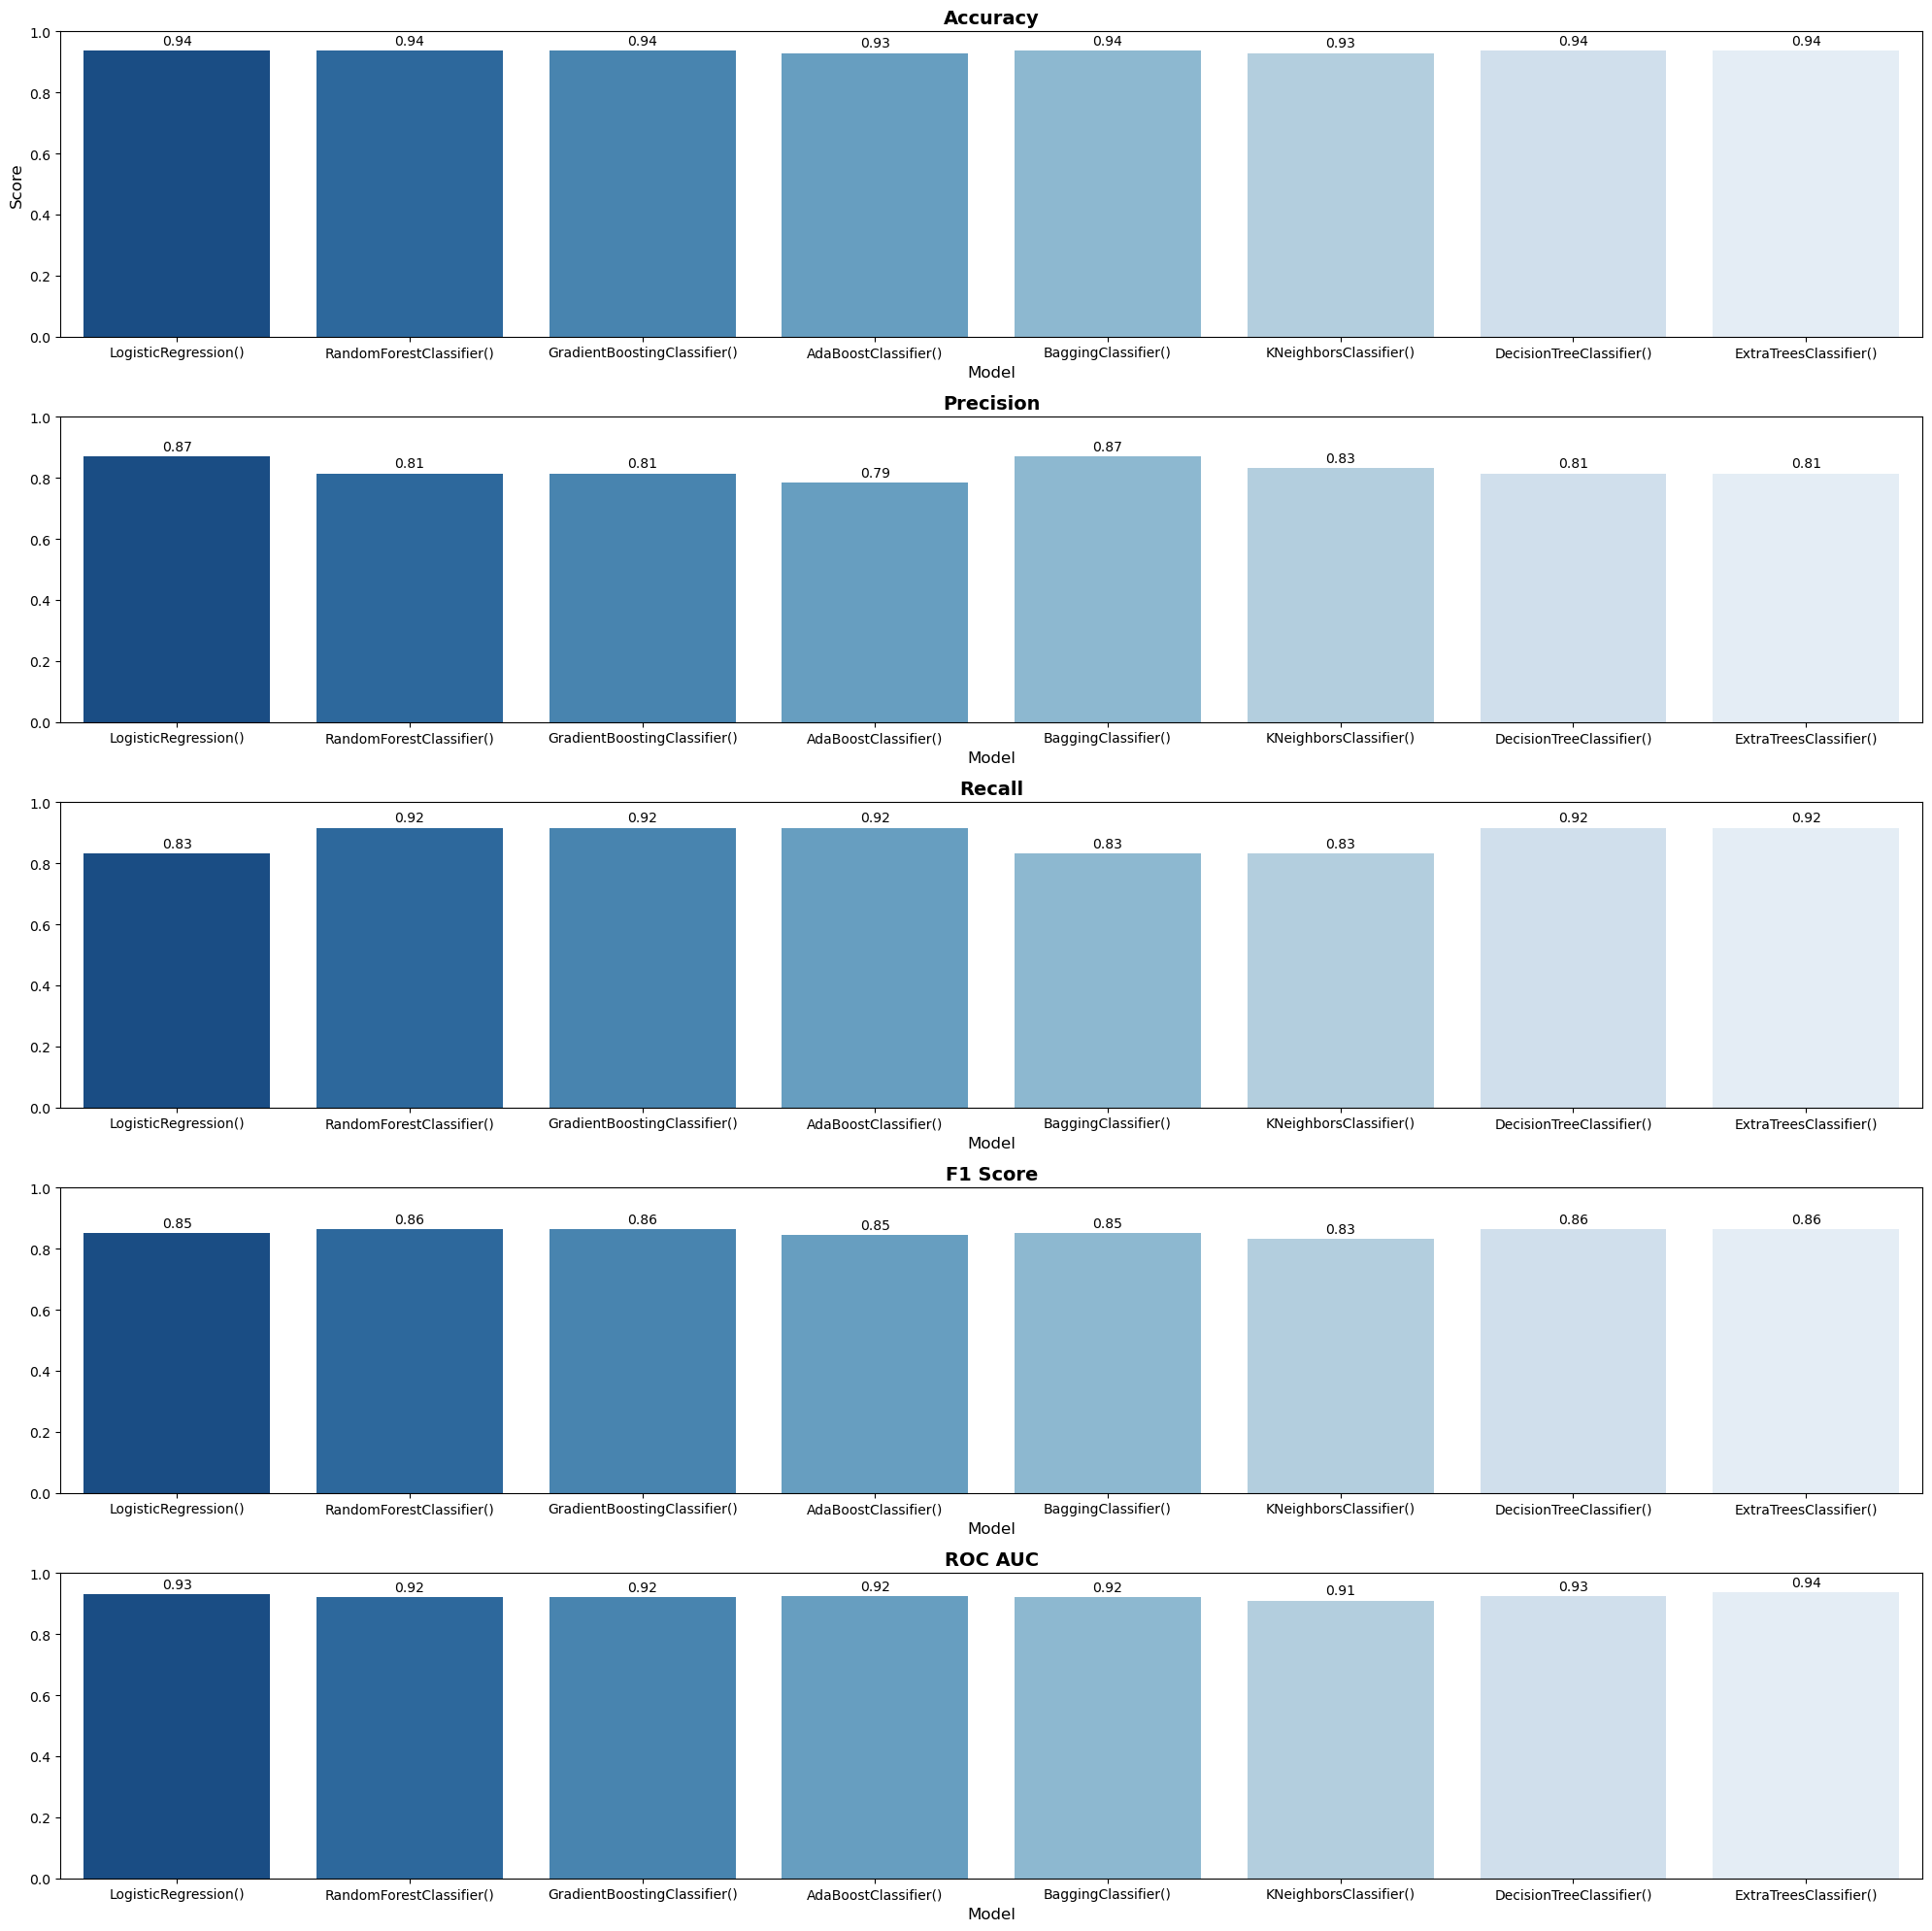

In [16]:
# Prepare data for plotting
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
metric_results = {metric: [] for metric in metrics}

# Collect data for each metric
for model, scores in model_metrics.items():
    for metric in metrics:
        metric_results[metric].append(scores.get(metric, 0))

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(20, 20), sharey=True)

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.barplot(x=list(model_metrics.keys()), y=metric_results[metric], palette="Blues_r", ax=ax)

    # Add labels to the bars
    for j, value in enumerate(metric_results[metric]):
        ax.text(j, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

    # Set labels and title
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylim([0,1])
    ax.set_title(metric, fontsize=14, weight='bold')
    ax.set_xticklabels(ax.get_xticklabels())

# Set common ylabel
axes[0].set_ylabel('Score', fontsize=12)

# Adjust layout
plt.tight_layout()

# Show plot
# plt.savefig('savefig/ClassificationModels.png')
plt.show()


After this shotgun method I decided to further investigate 3 models: Logistic Regressor, Bagging Classifier, and Extra Trees Classifier. First we are gonna start with the Logistic Regressor

## Logistic Regressor

In these deep dives into the 3 models, some more techniques were used to get better results from the models. Those techniques include scaling, SMOTE, and hyperparameter tuning.

In [17]:
# Select only the numeric features you want to scale
numeric_features = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level','Stress Level', 'Heart Rate', 'Daily Steps', 'Systolic', 'Diastolic']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform only the numeric features
df_scaled = pd.DataFrame(scaler.fit_transform(df[numeric_features]), columns=numeric_features)

# If you want to keep the non-numeric features in the DataFrame
df_scaled = pd.concat([df_scaled, df.drop(columns=numeric_features)], axis=1)

# Display the scaled data
df_scaled.head()


,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Systolic,Diastolic,Gender,BMI Category,insomnia_binary
0,-1.753096,-1.298887,-1.098280,-0.825418,0.347021,1.654719,-1.619584,-0.330002,-0.268102,1,3,0
1,-1.637643,-1.173036,-1.098280,0.039844,1.475592,1.170474,1.970077,-0.459239,-0.755640,1,0,0
2,-1.637643,-1.173036,-1.098280,0.039844,1.475592,1.170474,1.970077,-0.459239,-0.755640,1,0,0
3,-1.637643,-1.550588,-2.771424,-1.402260,1.475592,3.591698,-2.362273,1.479309,0.869486,1,2,0
4,-1.637643,-1.550588,-2.771424,-1.402260,1.475592,3.591698,-2.362273,1.479309,0.869486,1,2,0


In [18]:
features = df_scaled.drop(columns='insomnia_binary')
X_scaled = features
y_scaled = df_scaled['insomnia_binary']

In [19]:
oversample = over_sampling.SMOTE()
X_scaled, y_scaled = oversample.fit_resample(X_scaled, y_scaled)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y_scaled, test_size=0.3, random_state=36)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=36)

First we started with a baseline to compare the hyperparameters with

In [21]:
# Train the model
model = LogisticRegression(random_state=36)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Generate classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.91        98
           1       0.90      0.89      0.89        81

    accuracy                           0.91       179
   macro avg       0.90      0.90      0.90       179
weighted avg       0.90      0.91      0.90       179

Confusion Matrix:
[[90  8]
 [ 9 72]]


In [22]:
grid = dict()

grid["solver"] = ["newton-cg", "lbfgs", "liblinear"]
grid["penalty"] = ["l2"]
grid["C"] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

The first gridsearch is done with the hope of getting teh highest recall possible. I had to slightly adjust this formula as calling 'recall' in the scoring variable will give the recall for the negative variable. 

In [23]:
search = GridSearchCV(estimator=LogisticRegression(random_state=36),
                      param_grid=grid,
                      scoring=recall_scorer,
                      n_jobs=-1,
                      cv=cv)

result = search.fit(X_train, y_train)

print("> BEST SCORE: \t\t{}".format(result.best_score_))
print("> OPTIMAL PARAMETERS: \t{}".format(result.best_params_))

best_model = result.best_estimator_
y_pred = best_model.predict(X_test)

# Generate the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

> BEST SCORE: 		1.0
> OPTIMAL PARAMETERS: 	{'C': 1e-05, 'penalty': 'l2', 'solver': 'newton-cg'}

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.45      1.00      0.62        81

    accuracy                           0.45       179
   macro avg       0.23      0.50      0.31       179
weighted avg       0.20      0.45      0.28       179

Confusion Matrix:
[[ 0 98]
 [ 0 81]]


c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


After getting the ideal recall parameters, I wanted to find the ideal parameters for accuracy, which is seen below

In [24]:
search = GridSearchCV(estimator=LogisticRegression(random_state=36),
                      param_grid=grid,
                      scoring='accuracy',
                      n_jobs=-1,
                      cv=cv)

result = search.fit(X_train, y_train)

print("> BEST SCORE: \t\t{}".format(result.best_score_))
print("> OPTIMAL PARAMETERS: \t{}".format(result.best_params_))

best_model = result.best_estimator_
y_pred = best_model.predict(X_test)

# Generate the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

> BEST SCORE: 		0.89006968641115
> OPTIMAL PARAMETERS: 	{'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        98
           1       0.91      0.89      0.90        81

    accuracy                           0.91       179
   macro avg       0.91      0.91      0.91       179
weighted avg       0.91      0.91      0.91       179

Confusion Matrix:
[[91  7]
 [ 9 72]]


And lastly, the ideal parameters for 'precision' 

In [25]:
search = GridSearchCV(estimator=LogisticRegression(random_state=36),
                      param_grid=grid,
                      scoring='precision',
                      n_jobs=-1,
                      cv=cv)

result = search.fit(X_train, y_train)

print("> BEST SCORE: \t\t{}".format(result.best_score_))
print("> OPTIMAL PARAMETERS: \t{}".format(result.best_params_))

best_model = result.best_estimator_
y_pred = best_model.predict(X_test)

# Generate the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

> BEST SCORE: 		0.9044545715199236
> OPTIMAL PARAMETERS: 	{'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        98
           1       0.91      0.89      0.90        81

    accuracy                           0.91       179
   macro avg       0.91      0.91      0.91       179
weighted avg       0.91      0.91      0.91       179

Confusion Matrix:
[[91  7]
 [ 9 72]]


## Bagging Classifier

I then repeated the process for the Bagging Classifier which can be seen in the following steps, the only thing that was changed was the hyperparameter grid used for the GridSearch

In [26]:
# Select only the numeric features you want to scale
numeric_features = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level','Stress Level', 'Heart Rate', 'Daily Steps', 'Systolic', 'Diastolic']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform only the numeric features
df_scaled = pd.DataFrame(scaler.fit_transform(df[numeric_features]), columns=numeric_features)

# If you want to keep the non-numeric features in the DataFrame
df_scaled = pd.concat([df_scaled, df.drop(columns=numeric_features)], axis=1)

# Display the scaled data
df_scaled.head()

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Systolic,Diastolic,Gender,BMI Category,insomnia_binary
0,-1.753096,-1.298887,-1.098280,-0.825418,0.347021,1.654719,-1.619584,-0.330002,-0.268102,1,3,0
1,-1.637643,-1.173036,-1.098280,0.039844,1.475592,1.170474,1.970077,-0.459239,-0.755640,1,0,0
2,-1.637643,-1.173036,-1.098280,0.039844,1.475592,1.170474,1.970077,-0.459239,-0.755640,1,0,0
3,-1.637643,-1.550588,-2.771424,-1.402260,1.475592,3.591698,-2.362273,1.479309,0.869486,1,2,0
4,-1.637643,-1.550588,-2.771424,-1.402260,1.475592,3.591698,-2.362273,1.479309,0.869486,1,2,0


In [27]:
features = df_scaled.drop(columns='insomnia_binary')
X_scaled = features
y_scaled = df_scaled['insomnia_binary']

In [28]:
oversample = over_sampling.SMOTE()
X_scaled, y_scaled = oversample.fit_resample(X_scaled, y_scaled)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y_scaled, test_size=0.3, random_state=36)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=36)

In [30]:
# Train the model
model = BaggingClassifier(random_state=36)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Generate classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95        98
           1       0.95      0.94      0.94        81

    accuracy                           0.95       179
   macro avg       0.95      0.95      0.95       179
weighted avg       0.95      0.95      0.95       179

Confusion Matrix:
[[94  4]
 [ 5 76]]


In [31]:
param_grid_bc = {
    'estimator': [None, DecisionTreeClassifier(max_depth=5), DecisionTreeClassifier(max_depth=10)],
    'n_estimators': [10, 50, 100],  # Number of base estimators
    'max_samples': [0.5, 0.7, 1.0],  # Fraction of samples to draw from X to train each base estimator
    'max_features': [0.5, 0.7, 1.0],  # Fraction of features to draw from X to train each base estimator
    'bootstrap': [True, False],  # Whether to use bootstrap samples
    'bootstrap_features': [True, False],  # Whether to use bootstrap samples for features
    'n_jobs': [-1]  # Number of jobs to run in parallel
}

In [32]:
search = GridSearchCV(estimator=BaggingClassifier(random_state=36),
                      param_grid=param_grid_bc,
                      scoring=recall_scorer,
                      n_jobs=-1,
                      cv=cv)

result = search.fit(X_train, y_train)

print("> BEST SCORE: \t\t{}".format(result.best_score_))
print("> OPTIMAL PARAMETERS: \t{}".format(result.best_params_))

best_model = result.best_estimator_
y_pred = best_model.predict(X_test)

# Generate the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

> BEST SCORE: 		0.9233389533454369
> OPTIMAL PARAMETERS: 	{'bootstrap': False, 'bootstrap_features': True, 'estimator': DecisionTreeClassifier(max_depth=5), 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': -1}

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95        98
           1       0.95      0.94      0.94        81

    accuracy                           0.95       179
   macro avg       0.95      0.95      0.95       179
weighted avg       0.95      0.95      0.95       179

Confusion Matrix:
[[94  4]
 [ 5 76]]


In [33]:
search = GridSearchCV(estimator=BaggingClassifier(random_state=36),
                      param_grid=param_grid_bc,
                      scoring='accuracy',
                      n_jobs=-1,
                      cv=cv)

result = search.fit(X_train, y_train)

print("> BEST SCORE: \t\t{}".format(result.best_score_))
print("> OPTIMAL PARAMETERS: \t{}".format(result.best_params_))

best_model = result.best_estimator_
y_pred = best_model.predict(X_test)

# Generate the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

> BEST SCORE: 		0.9333914053426249
> OPTIMAL PARAMETERS: 	{'bootstrap': False, 'bootstrap_features': True, 'estimator': None, 'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 100, 'n_jobs': -1}

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95        98
           1       0.95      0.94      0.94        81

    accuracy                           0.95       179
   macro avg       0.95      0.95      0.95       179
weighted avg       0.95      0.95      0.95       179

Confusion Matrix:
[[94  4]
 [ 5 76]]


In [34]:
search = GridSearchCV(estimator=BaggingClassifier(random_state=36),
                      param_grid=param_grid_bc,
                      scoring='precision',
                      n_jobs=-1,
                      cv=cv)

result = search.fit(X_train, y_train)

print("> BEST SCORE: \t\t{}".format(result.best_score_))
print("> OPTIMAL PARAMETERS: \t{}".format(result.best_params_))

best_model = result.best_estimator_
y_pred = best_model.predict(X_test)

# Generate the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

> BEST SCORE: 		0.9597576022313535
> OPTIMAL PARAMETERS: 	{'bootstrap': False, 'bootstrap_features': True, 'estimator': None, 'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 100, 'n_jobs': -1}

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95        98
           1       0.95      0.94      0.94        81

    accuracy                           0.95       179
   macro avg       0.95      0.95      0.95       179
weighted avg       0.95      0.95      0.95       179

Confusion Matrix:
[[94  4]
 [ 5 76]]


## Extra Trees Classifier

Similar to the Bagging Classifier, this is the same process as the Logistic Regressor, with the only difference being in the grid used for the GridSearch. 

In [73]:
# Select only the numeric features you want to scale
numeric_features = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level','Stress Level', 'Heart Rate', 'Daily Steps', 'Systolic', 'Diastolic']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform only the numeric features
df_scaled = pd.DataFrame(scaler.fit_transform(df[numeric_features]), columns=numeric_features)

# If you want to keep the non-numeric features in the DataFrame
df_scaled = pd.concat([df_scaled, df.drop(columns=numeric_features)], axis=1)

# Display the scaled data
df_scaled.head()

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Systolic,Diastolic,Gender,BMI Category,insomnia_binary
0,-1.753096,-1.298887,-1.098280,-0.825418,0.347021,1.654719,-1.619584,-0.330002,-0.268102,1,3,0
1,-1.637643,-1.173036,-1.098280,0.039844,1.475592,1.170474,1.970077,-0.459239,-0.755640,1,0,0
2,-1.637643,-1.173036,-1.098280,0.039844,1.475592,1.170474,1.970077,-0.459239,-0.755640,1,0,0
3,-1.637643,-1.550588,-2.771424,-1.402260,1.475592,3.591698,-2.362273,1.479309,0.869486,1,2,0
4,-1.637643,-1.550588,-2.771424,-1.402260,1.475592,3.591698,-2.362273,1.479309,0.869486,1,2,0


In [74]:
features = df_scaled.drop(columns='insomnia_binary')
X_scaled = features
y_scaled = df_scaled['insomnia_binary']

In [75]:
oversample = over_sampling.SMOTE()
X_scaled, y_scaled = oversample.fit_resample(X_scaled, y_scaled)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y_scaled, test_size=0.3, random_state=36)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=36)

In [39]:
# Train the model
model = ExtraTreesClassifier(random_state=36)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Generate classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95        98
           1       0.95      0.94      0.94        81

    accuracy                           0.95       179
   macro avg       0.95      0.95      0.95       179
weighted avg       0.95      0.95      0.95       179

Confusion Matrix:
[[94  4]
 [ 5 76]]


In [40]:
param_grid_etc = {
    'n_estimators': [50, 100, 200],         # Number of trees in the forest
    'max_features': ['auto', 'sqrt', 'log2'], # Number of features to consider for the best split
    'max_depth': [None, 10, 20, 30],        # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],         # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],           # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False],              # Whether to use bootstrap samples
    'n_jobs': [-1]                           # Number of jobs to run in parallel
}

In [41]:
search = GridSearchCV(estimator=ExtraTreesClassifier(random_state=36),
                      param_grid=param_grid_etc,
                      scoring=recall_scorer,
                      n_jobs=-1,
                      cv=cv)

result = search.fit(X_train, y_train)

print("> BEST SCORE: \t\t{}".format(result.best_score_))
print("> OPTIMAL PARAMETERS: \t{}".format(result.best_params_))

best_model = result.best_estimator_
y_pred = best_model.predict(X_test)

# Generate the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

> BEST SCORE: 		0.9466173717868988
> OPTIMAL PARAMETERS: 	{'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50, 'n_jobs': -1}

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        98
           1       0.95      0.95      0.95        81

    accuracy                           0.96       179
   macro avg       0.95      0.95      0.95       179
weighted avg       0.96      0.96      0.96       179

Confusion Matrix:
[[94  4]
 [ 4 77]]


c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
6480 fits failed out of a total of 19440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4837 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(


In [42]:
search = GridSearchCV(estimator=ExtraTreesClassifier(random_state=36),
                      param_grid=param_grid_etc,
                      scoring='accuracy',
                      n_jobs=-1,
                      cv=cv)

result = search.fit(X_train, y_train)

print("> BEST SCORE: \t\t{}".format(result.best_score_))
print("> OPTIMAL PARAMETERS: \t{}".format(result.best_params_))

best_model = result.best_estimator_
y_pred = best_model.predict(X_test)

# Generate the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
6480 fits failed out of a total of 19440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1812 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(


> BEST SCORE: 		0.9477739063104917
> OPTIMAL PARAMETERS: 	{'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'n_jobs': -1}

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95        98
           1       0.95      0.94      0.94        81

    accuracy                           0.95       179
   macro avg       0.95      0.95      0.95       179
weighted avg       0.95      0.95      0.95       179

Confusion Matrix:
[[94  4]
 [ 5 76]]


In [43]:
search = GridSearchCV(estimator=ExtraTreesClassifier(random_state=36),
                      param_grid=param_grid_etc,
                      scoring='precision',
                      n_jobs=-1,
                      cv=cv)

result = search.fit(X_train, y_train)

print("> BEST SCORE: \t\t{}".format(result.best_score_))
print("> OPTIMAL PARAMETERS: \t{}".format(result.best_params_))

best_model = result.best_estimator_
y_pred = best_model.predict(X_test)

# Generate the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
6480 fits failed out of a total of 19440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4890 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(


> BEST SCORE: 		0.9657731158154498
> OPTIMAL PARAMETERS: 	{'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'n_jobs': -1}

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95        98
           1       0.95      0.94      0.94        81

    accuracy                           0.95       179
   macro avg       0.95      0.95      0.95       179
weighted avg       0.95      0.95      0.95       179

Confusion Matrix:
[[94  4]
 [ 5 76]]


before using LDA/PCA and a threshold, I wanted to see what features are most important in for the model to use in prediction

                    Feature  Importance
10             BMI Category    0.197887
3   Physical Activity Level    0.151925
1            Sleep Duration    0.116922
8                 Diastolic    0.100319
7                  Systolic    0.094501
6               Daily Steps    0.093820
0                       Age    0.068577
2          Quality of Sleep    0.063744
4              Stress Level    0.056903
5                Heart Rate    0.035066
9                    Gender    0.020336


C:\Users\Shank\AppData\Local\Temp\ipykernel_12116\618551828.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_r')


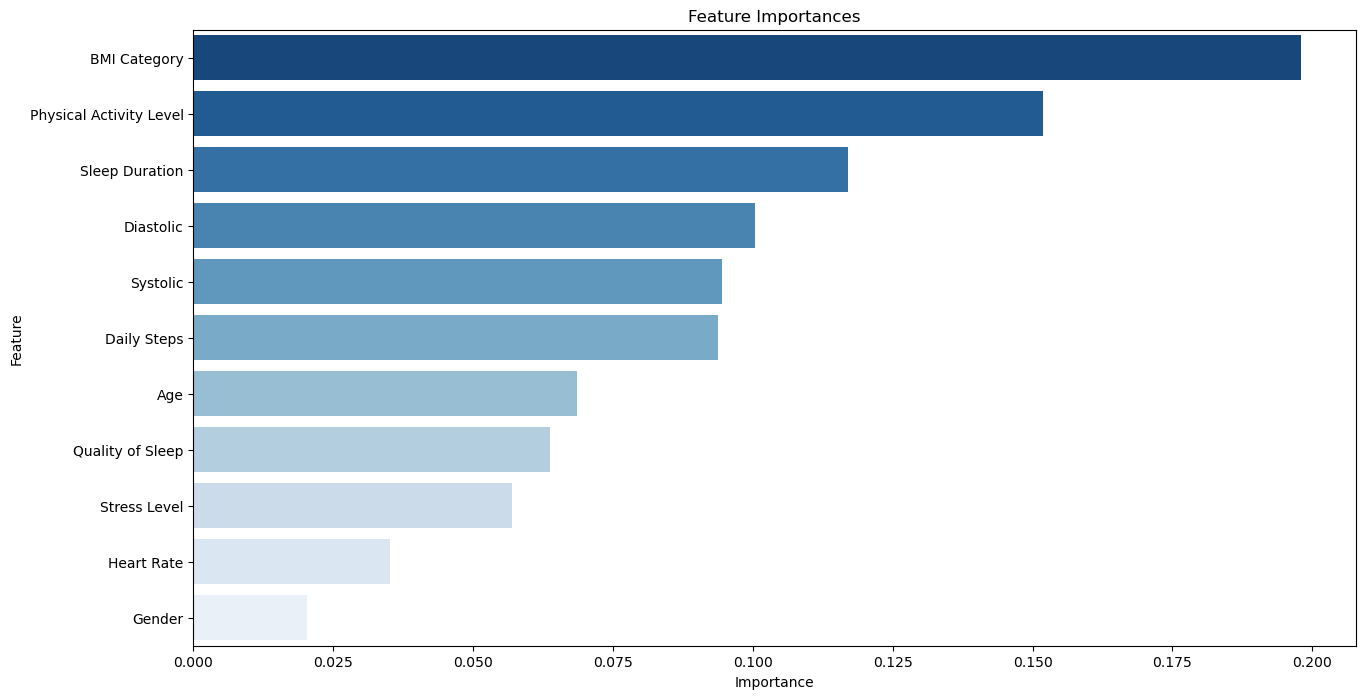

In [83]:
model = ExtraTreesClassifier(bootstrap=False, 
                             max_depth=None, 
                             max_features='sqrt', 
                             min_samples_leaf=1, 
                             min_samples_split=2, 
                             n_estimators=200, 
                             n_jobs=-1,
                             random_state=36)

model.fit(X_train, y_train)

# Extracting the feature importances from the model
feature_importances = model.feature_importances_

# Creating a DataFrame to display the feature importances
importance_df = pd.DataFrame({
    'Feature': numeric_features + ['Gender', 'BMI Category'],
    'Importance': feature_importances
})

# Sorting the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Displaying the feature importances
print(importance_df)

# Plotting the feature importances
plt.figure(figsize=(15, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_r')
plt.title('Feature Importances')
plt.savefig('feature_importances.png', transparent=True)
plt.show()


_________

## Insomnia Model Tuning

Now that I got a good understanding for which models are ideal to use for this model, I am going to adjust the features and tuning of it to get the model to perform exactly how I want it to

A lot of the steps that were seen in the hyperparameter tuning steps are reused here with the main addition being the use of LDA/PCA and a threshold when determining which binary variable the predicted value belongs in.

In [44]:
# Select only the numeric features you want to scale
numeric_features = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level','Stress Level', 'Heart Rate', 'Daily Steps', 'Systolic', 'Diastolic']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform only the numeric features
df_scaled = pd.DataFrame(scaler.fit_transform(df[numeric_features]), columns=numeric_features)

# If you want to keep the non-numeric features in the DataFrame
df_scaled = pd.concat([df_scaled, df.drop(columns=numeric_features)], axis=1)

# Display the scaled data
df_scaled.head()

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Systolic,Diastolic,Gender,BMI Category,insomnia_binary
0,-1.753096,-1.298887,-1.098280,-0.825418,0.347021,1.654719,-1.619584,-0.330002,-0.268102,1,3,0
1,-1.637643,-1.173036,-1.098280,0.039844,1.475592,1.170474,1.970077,-0.459239,-0.755640,1,0,0
2,-1.637643,-1.173036,-1.098280,0.039844,1.475592,1.170474,1.970077,-0.459239,-0.755640,1,0,0
3,-1.637643,-1.550588,-2.771424,-1.402260,1.475592,3.591698,-2.362273,1.479309,0.869486,1,2,0
4,-1.637643,-1.550588,-2.771424,-1.402260,1.475592,3.591698,-2.362273,1.479309,0.869486,1,2,0


In [45]:
features = df_scaled.drop(columns=['insomnia_binary', 'Heart Rate', 'Gender', 'BMI Category'])
X_scaled = features
y_scaled = df_scaled['insomnia_binary']

In [46]:
oversample = over_sampling.SMOTE()
X, y = oversample.fit_resample(X_scaled, y_scaled)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=36)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=36)

In [48]:
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [49]:
model = ExtraTreesClassifier(bootstrap=False, 
                             max_depth=None, 
                             max_features='sqrt', 
                             min_samples_leaf=1, 
                             min_samples_split=2, 
                             n_estimators=200, 
                             n_jobs=-1,
                             random_state=36)

model.fit(X_train_pca,y_train)
y_pred = model.predict(X_test_pca)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))


# Predict probabilities to adjust the decision threshold
y_pred_proba = model.predict_proba(X_test_pca)[:, 1]

# Adjust the threshold (lower threshold increases sensitivity to positives)
threshold = 0.1
y_pred_thres = (y_pred_proba >= threshold).astype(int)

# Evaluate the model
print("Confusion Matrix w/Threshold:")
print(confusion_matrix(y_test, y_pred_thres))
print("\nClassification Report w/Threshold:")
print(classification_report(y_test, y_pred_thres))
print("\nAccuracy Score w/Threshold:")
print(accuracy_score(y_test, y_pred_thres))

Confusion Matrix:
[[93  5]
 [ 6 75]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94        98
           1       0.94      0.93      0.93        81

    accuracy                           0.94       179
   macro avg       0.94      0.94      0.94       179
weighted avg       0.94      0.94      0.94       179


Accuracy Score:
0.9385474860335196
Confusion Matrix w/Threshold:
[[83 15]
 [ 2 79]]

Classification Report w/Threshold:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91        98
           1       0.84      0.98      0.90        81

    accuracy                           0.91       179
   macro avg       0.91      0.91      0.90       179
weighted avg       0.91      0.91      0.91       179


Accuracy Score w/Threshold:
0.9050279329608939


# The Pipeline

In [50]:
# Define the numeric features for scaling
numeric_features = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 
                    'Stress Level', 'Daily Steps', 'Systolic', 'Diastolic']

In [51]:
# Define the preprocessing step
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ], remainder='passthrough')

In [52]:
# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=3)),
    ('model', ExtraTreesClassifier(bootstrap=False, 
                                   max_depth=None, 
                                   max_features='sqrt', 
                                   min_samples_leaf=1, 
                                   min_samples_split=2, 
                                   n_estimators=200, 
                                   n_jobs=-1,
                                   random_state=36))
])

In [53]:
# Separate features and target variable
features = df.drop(columns=['insomnia_binary', 'Heart Rate', 'Gender', 'BMI Category'])
X_scaled = features
y_scaled = df['insomnia_binary']


In [54]:
# Apply SMOTE for oversampling
oversample = SMOTE(random_state=36)
X, y = oversample.fit_resample(X_scaled, y_scaled)

In [55]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=36)

In [56]:
X_train.head()

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Daily Steps,Systolic,Diastolic
498,43,6.5,6,45,7,6000,130,85
346,57,8.2,9,75,3,7000,140,95
67,33,6.0,6,30,8,5000,125,80
516,44,6.3,6,45,7,6000,130,85
561,44,6.4,6,45,7,6000,130,85


In [57]:
# Train the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

Confusion Matrix:
[[94  4]
 [ 6 75]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        98
           1       0.95      0.93      0.94        81

    accuracy                           0.94       179
   macro avg       0.94      0.94      0.94       179
weighted avg       0.94      0.94      0.94       179


Accuracy Score:
0.9441340782122905


In [58]:
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict probabilities using the pipeline
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Adjust the threshold
threshold = 0.08
y_pred_thres = (y_pred_proba >= threshold).astype(int)

# Evaluate the model with the adjusted threshold
print("Confusion Matrix w/Threshold:")
print(confusion_matrix(y_test, y_pred_thres))
print("\nClassification Report w/Threshold:")
print(classification_report(y_test, y_pred_thres))
print("\nAccuracy Score w/Threshold:")
print(accuracy_score(y_test, y_pred_thres))

Confusion Matrix w/Threshold:
[[81 17]
 [ 3 78]]

Classification Report w/Threshold:
              precision    recall  f1-score   support

           0       0.96      0.83      0.89        98
           1       0.82      0.96      0.89        81

    accuracy                           0.89       179
   macro avg       0.89      0.89      0.89       179
weighted avg       0.90      0.89      0.89       179


Accuracy Score w/Threshold:
0.888268156424581


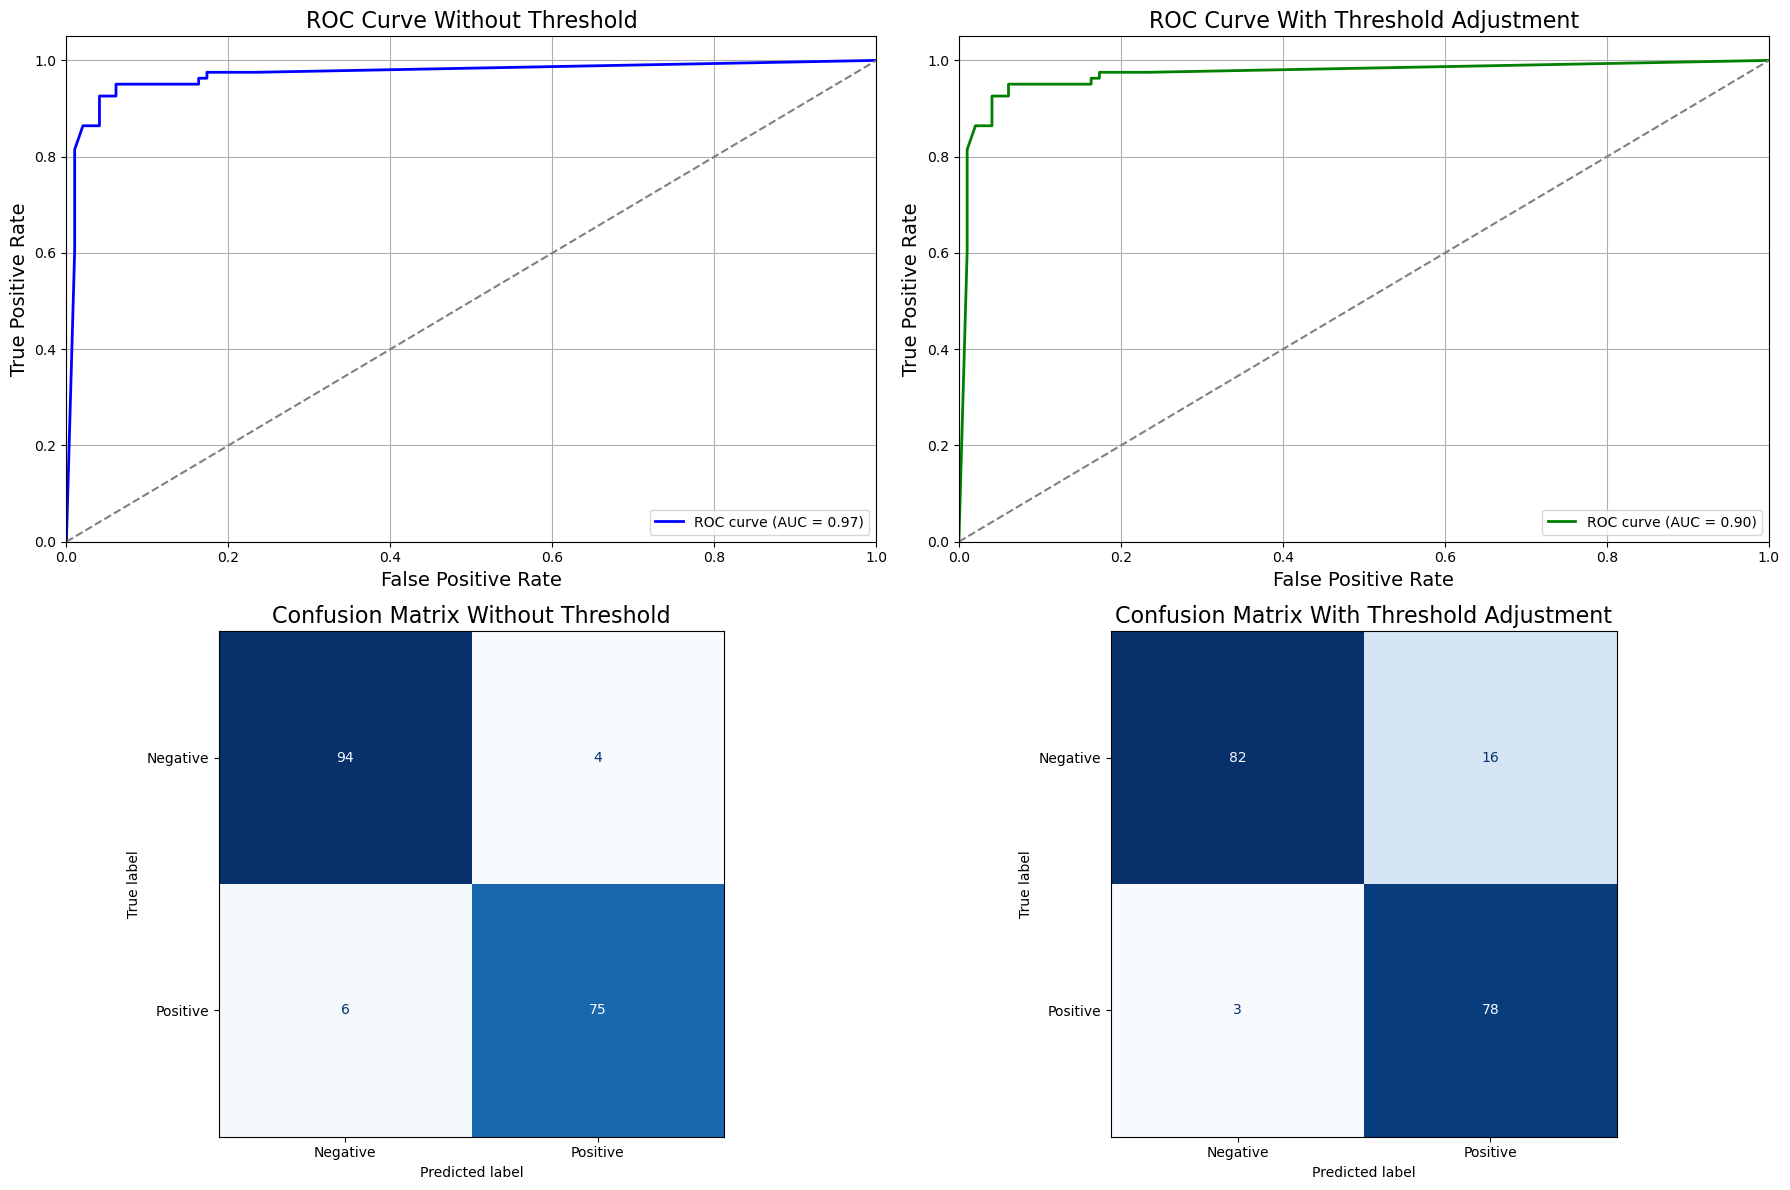

In [59]:
# Predict probabilities and predictions using the pipeline
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
y_pred = pipeline.predict(X_test)

# Compute ROC curve without threshold adjustment
fpr_no_thresh, tpr_no_thresh, _ = roc_curve(y_test, y_pred_proba)
roc_auc_no_thresh = roc_auc_score(y_test, y_pred_proba)

# Adjust the threshold
threshold = 0.1
y_pred_thres = (y_pred_proba >= threshold).astype(int)

# Compute ROC curve with threshold adjustment
fpr_thresh, tpr_thresh, _ = roc_curve(y_test, y_pred_proba)
roc_auc_thresh = roc_auc_score(y_test, y_pred_thres)

# Compute confusion matrices
conf_matrix_no_thresh = confusion_matrix(y_test, y_pred)
conf_matrix_thresh = confusion_matrix(y_test, y_pred_thres)

# Create subplots for ROC curves and confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot ROC curve without threshold adjustment
axes[0, 0].plot(fpr_no_thresh, tpr_no_thresh, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_no_thresh:.2f})')
axes[0, 0].plot([0, 1], [0, 1], color='grey', linestyle='--')
axes[0, 0].set_xlim([0.0, 1.0])
axes[0, 0].set_ylim([0.0, 1.05])
axes[0, 0].set_xlabel('False Positive Rate', fontsize=14)
axes[0, 0].set_ylabel('True Positive Rate', fontsize=14)
axes[0, 0].set_title('ROC Curve Without Threshold', fontsize=16)
axes[0, 0].legend(loc='lower right')
axes[0, 0].grid(True)

# Plot ROC curve with threshold adjustment
axes[0, 1].plot(fpr_thresh, tpr_thresh, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc_thresh:.2f})')
axes[0, 1].plot([0, 1], [0, 1], color='grey', linestyle='--')
axes[0, 1].set_xlim([0.0, 1.0])
axes[0, 1].set_ylim([0.0, 1.05])
axes[0, 1].set_xlabel('False Positive Rate', fontsize=14)
axes[0, 1].set_ylabel('True Positive Rate', fontsize=14)
axes[0, 1].set_title('ROC Curve With Threshold Adjustment', fontsize=16)
axes[0, 1].legend(loc='lower right')
axes[0, 1].grid(True)

# Plot confusion matrix without threshold adjustment
disp_no_thresh = ConfusionMatrixDisplay(conf_matrix_no_thresh, display_labels=['Negative', 'Positive'])
disp_no_thresh.plot(ax=axes[1, 0], cmap='Blues', colorbar=False, values_format='d')
axes[1, 0].set_title('Confusion Matrix Without Threshold', fontsize=16)

# Plot confusion matrix with threshold adjustment
disp_thresh = ConfusionMatrixDisplay(conf_matrix_thresh, display_labels=['Negative', 'Positive'])
disp_thresh.plot(ax=axes[1, 1], cmap='Blues', colorbar=False, values_format='d')
axes[1, 1].set_title('Confusion Matrix With Threshold Adjustment', fontsize=16)

plt.tight_layout()
plt.show()


# Final Pipeline

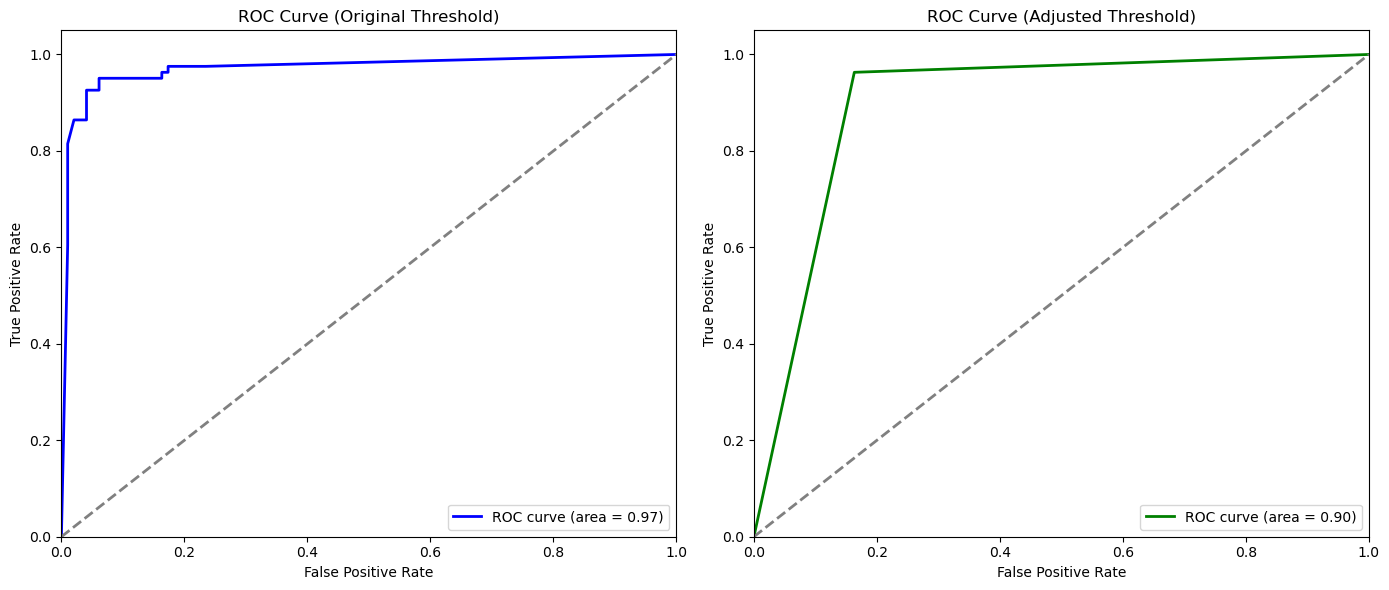

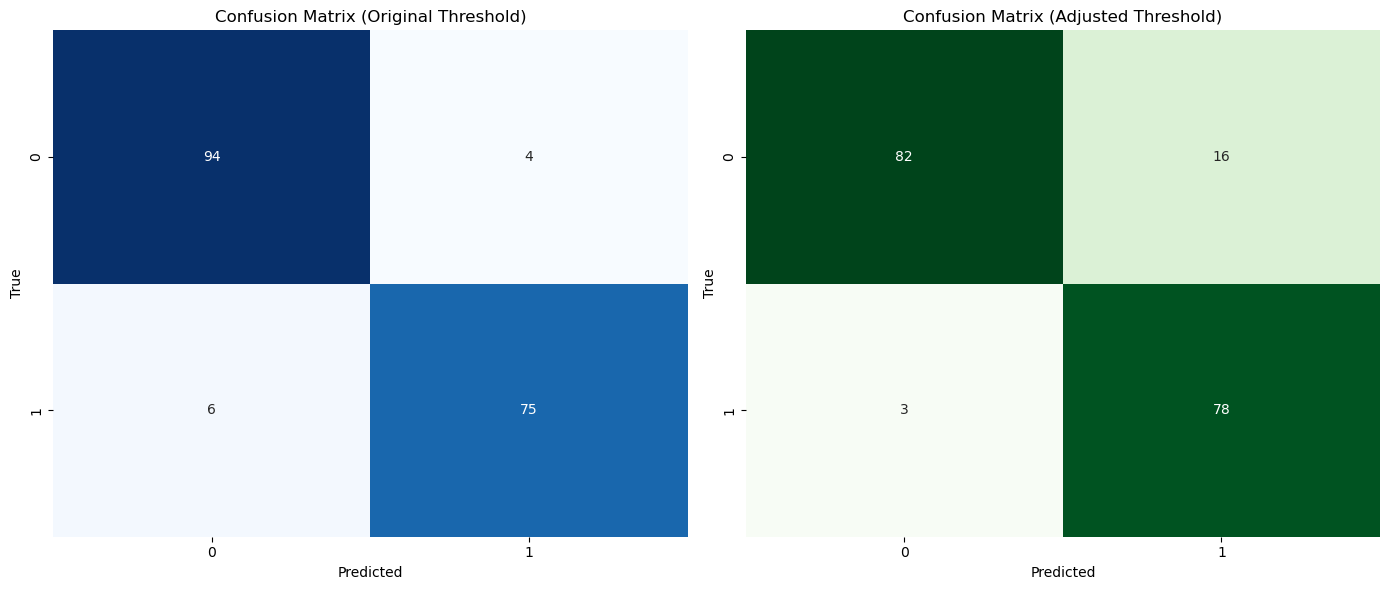

In [66]:
# Additional preprocessing steps
label_encoder = LabelEncoder()
for column in ['Gender', 'BMI Category']:
    df[column] = label_encoder.fit_transform(df[column])

# Defining the features and target variable
numeric_features = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level','Stress Level', 'Daily Steps', 'Systolic', 'Diastolic']
X = df[numeric_features]
y = df['insomnia_binary']

# Creating the pipeline
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=3)),
    ('model', ExtraTreesClassifier(bootstrap=False, 
                                   max_depth=None, 
                                   max_features='sqrt', 
                                   min_samples_leaf=1, 
                                   min_samples_split=2, 
                                   n_estimators=200, 
                                   n_jobs=-1,
                                   random_state=36))
])

# Applying SMOTE for oversampling
oversample = SMOTE(random_state=36)
X_resampled, y_resampled = oversample.fit_resample(X, y)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=36)

# Fitting the pipeline
pipeline.fit(X_train, y_train)

# Predicting probabilities to adjust the decision threshold
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Plotting ROC curves
plt.figure(figsize=(14, 6))

# ROC curve without threshold adjustment
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Original Threshold)')
plt.legend(loc="lower right")

# Adjusting the threshold (lower threshold increases sensitivity to positives)
threshold = 0.1
y_pred_thres = (y_pred_proba >= threshold).astype(int)

# ROC curve with threshold adjustment
fpr_thres, tpr_thres, _ = roc_curve(y_test, y_pred_thres)
roc_auc_thres = auc(fpr_thres, tpr_thres)
plt.subplot(1, 2, 2)
plt.plot(fpr_thres, tpr_thres, color='green', lw=2, label=f'ROC curve (area = {roc_auc_thres:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Adjusted Threshold)')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# Plotting confusion matrices
plt.figure(figsize=(14, 6))

# Confusion matrix without threshold adjustment
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, pipeline.predict(X_test)), annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix (Original Threshold)')
plt.xlabel('Predicted')
plt.ylabel('True')

# Confusion matrix with threshold adjustment
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_thres), annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title('Confusion Matrix (Adjusted Threshold)')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()


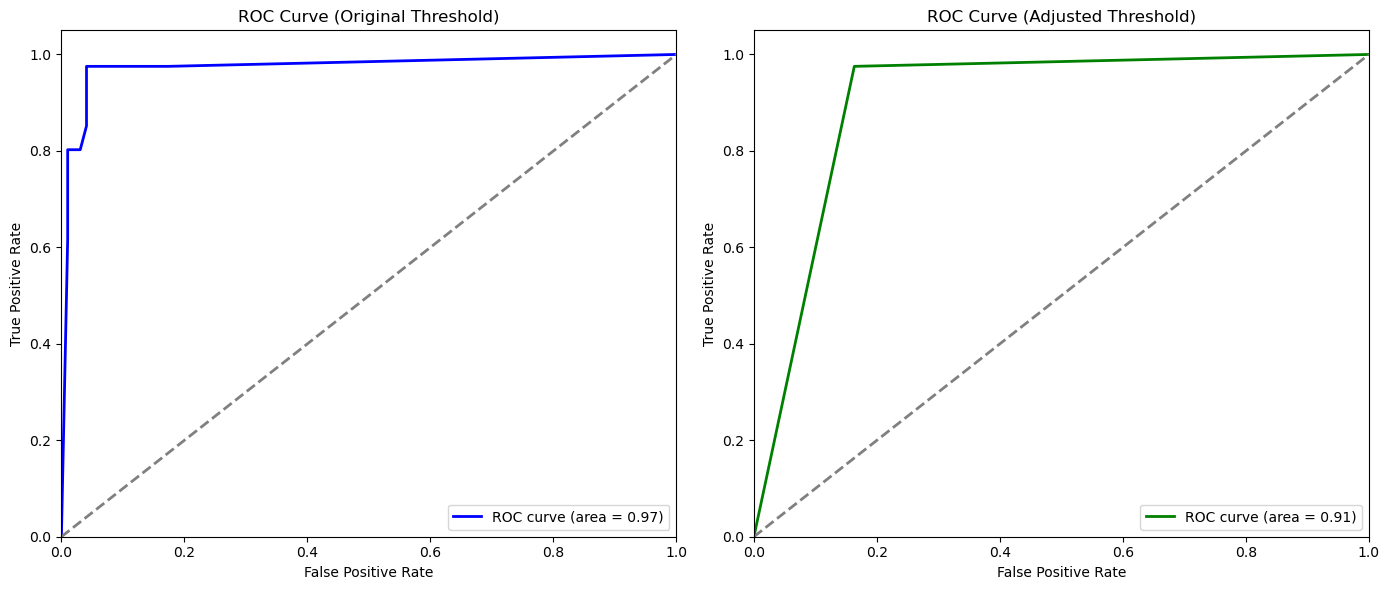

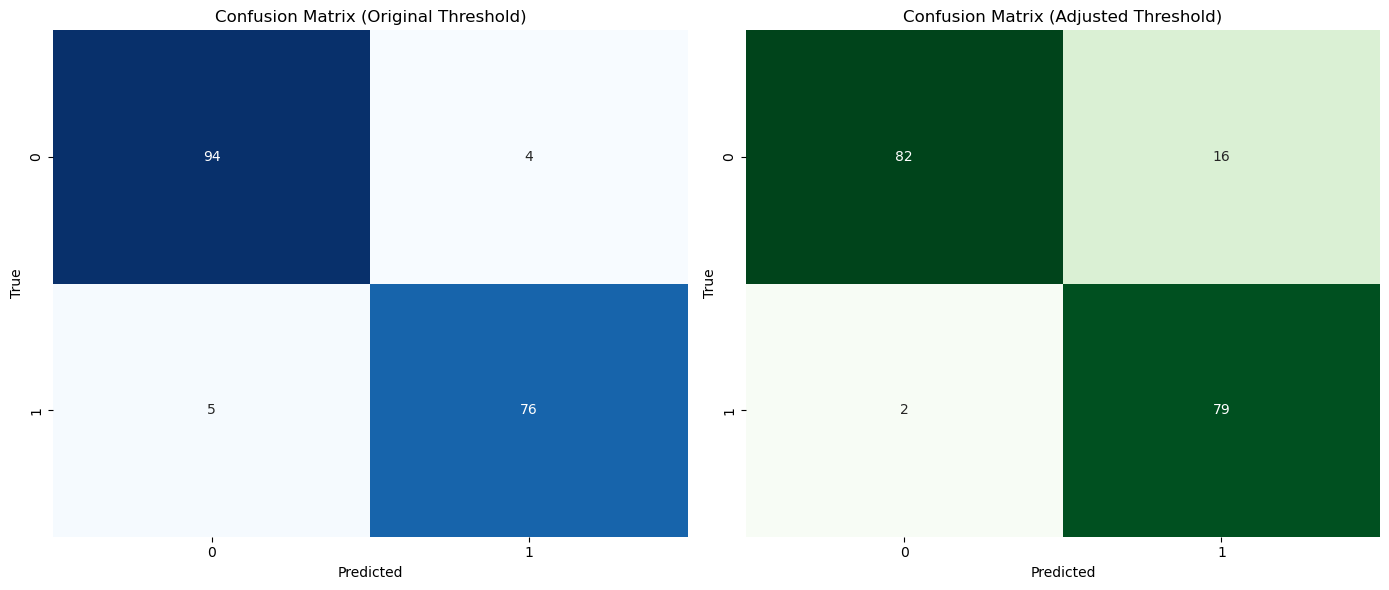

In [84]:
# Additional preprocessing steps
label_encoder = LabelEncoder()
for column in ['Gender', 'BMI Category']:
    df[column] = label_encoder.fit_transform(df[column])

# Defining the features and target variable
numeric_features = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 
                    'Stress Level', 'Daily Steps', 'Systolic', 'Diastolic', 'Gender', 'BMI Category']
X = df[numeric_features]
y = df['insomnia_binary']

# Creating the model pipeline (without scaling and PCA)
pipeline = Pipeline(steps=[
    ('model', ExtraTreesClassifier(bootstrap=False, 
                                   max_depth=None, 
                                   max_features='sqrt', 
                                   min_samples_leaf=1, 
                                   min_samples_split=2, 
                                   n_estimators=200, 
                                   n_jobs=-1,
                                   random_state=36))
])

# Applying SMOTE for oversampling
oversample = SMOTE(random_state=36)
X_resampled, y_resampled = oversample.fit_resample(X, y)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=36)

# Fitting the pipeline
pipeline.fit(X_train, y_train)

# Predicting probabilities to adjust the decision threshold
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Adjusting the threshold (lower threshold increases sensitivity to positives)
threshold = 0.1
y_pred_thres = (y_pred_proba >= threshold).astype(int)

# Plotting ROC curves
plt.figure(figsize=(14, 6))

# ROC curve without threshold adjustment
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Original Threshold)')
plt.legend(loc="lower right")

# ROC curve with threshold adjustment
fpr_thres, tpr_thres, _ = roc_curve(y_test, y_pred_thres)
roc_auc_thres = auc(fpr_thres, tpr_thres)
plt.subplot(1, 2, 2)
plt.plot(fpr_thres, tpr_thres, color='green', lw=2, label=f'ROC curve (area = {roc_auc_thres:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Adjusted Threshold)')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# Plotting confusion matrices
plt.figure(figsize=(14, 6))

# Confusion matrix without threshold adjustment
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, pipeline.predict(X_test)), annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix (Original Threshold)')
plt.xlabel('Predicted')
plt.ylabel('True')

# Confusion matrix with threshold adjustment
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_thres), annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title('Confusion Matrix (Adjusted Threshold)')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()


                   Feature  Importance
9             BMI Category    0.198981
1           Sleep Duration    0.140376
3  Physical Activity Level    0.137363
6                 Systolic    0.106986
7                Diastolic    0.092348
5              Daily Steps    0.086776
2         Quality of Sleep    0.078387
0                      Age    0.075668
4             Stress Level    0.065221
8                   Gender    0.017893


C:\Users\Shank\AppData\Local\Temp\ipykernel_12116\179177169.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_r')


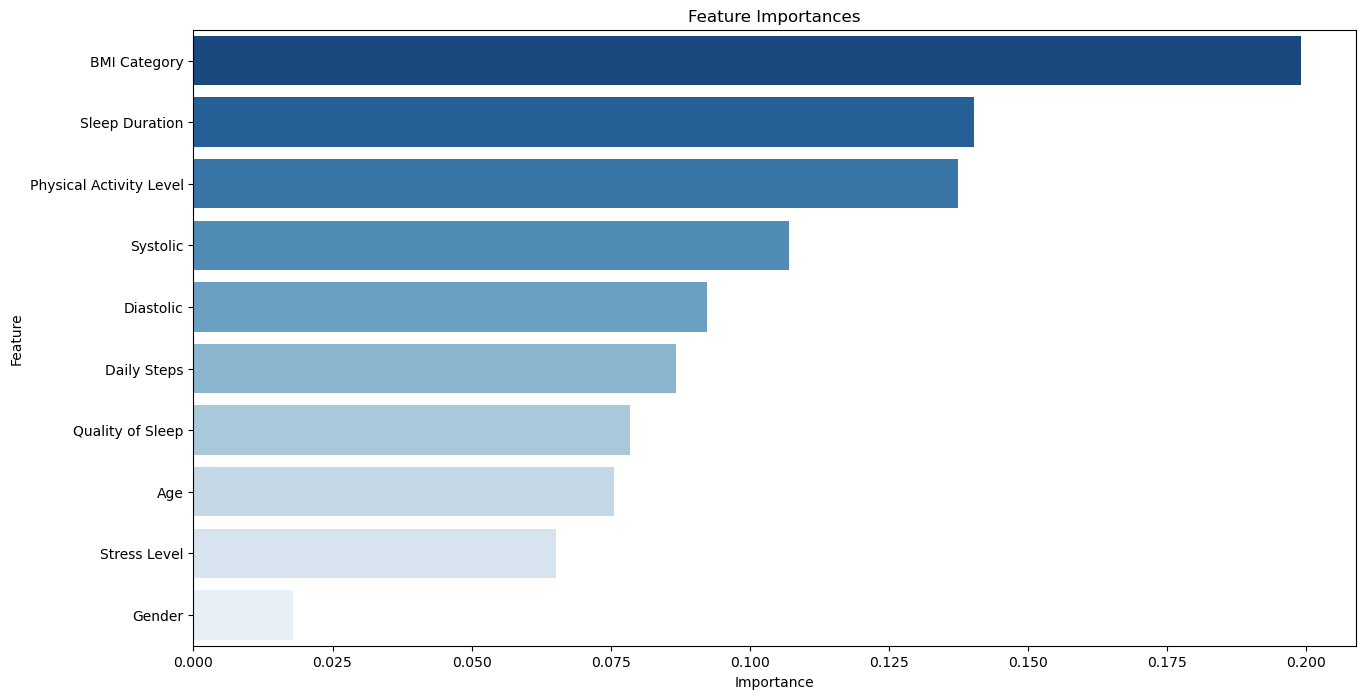

In [87]:
# Extracting the feature importances from the model
feature_importances = pipeline.named_steps['model'].feature_importances_

# Creating a DataFrame to display the feature importances
importance_df = pd.DataFrame({
    'Feature': numeric_features,
    'Importance': feature_importances
})

# Sorting the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Displaying the feature importances
print(importance_df)

# Plotting the feature importances
plt.figure(figsize=(15, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_r')
plt.title('Feature Importances')
plt.savefig('feature_importances.png', transparent=True)
plt.show()


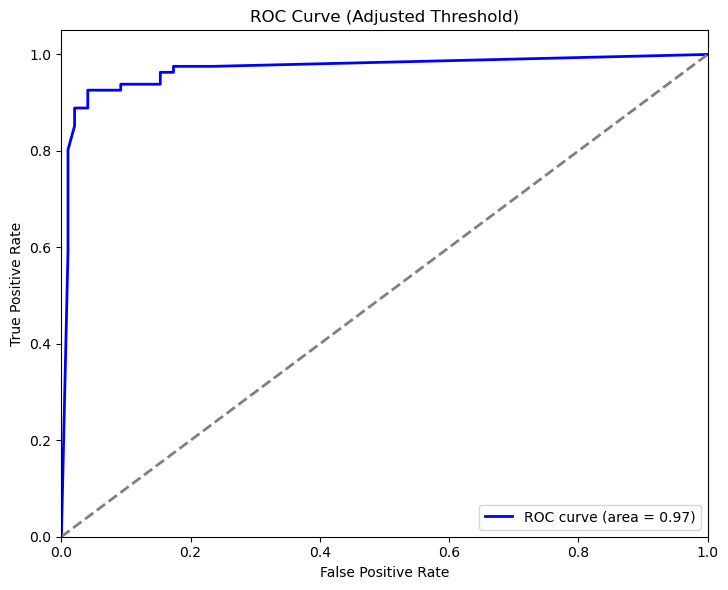

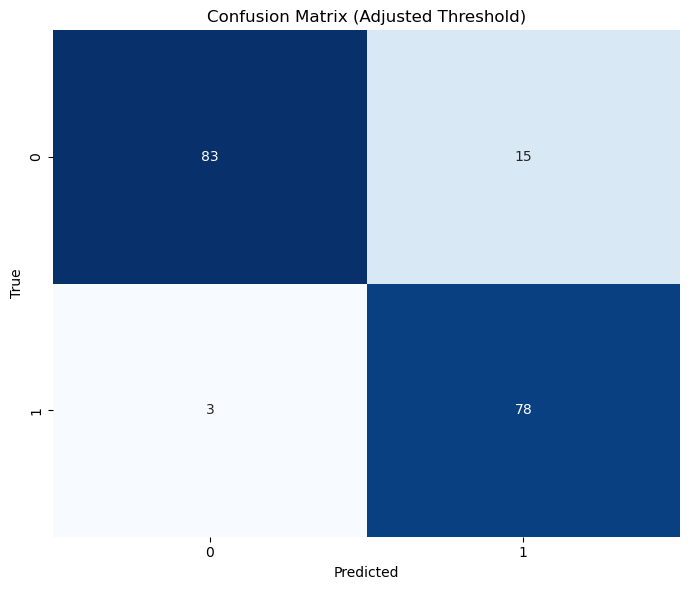

In [94]:
# Additional preprocessing steps
label_encoder = LabelEncoder()
for column in ['Gender', 'BMI Category']:
    df[column] = label_encoder.fit_transform(df[column])

# Defining the features and target variable
numeric_features = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 
                    'Stress Level', 'Daily Steps', 'Systolic', 'Diastolic', 'BMI Category']
X = df[numeric_features]
y = df['insomnia_binary']

# Creating the pipeline with scaler, PCA, and model
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=3)),
    ('model', ExtraTreesClassifier(bootstrap=False, 
                                   max_depth=None, 
                                   max_features='sqrt', 
                                   min_samples_leaf=1, 
                                   min_samples_split=2, 
                                   n_estimators=200, 
                                   n_jobs=-1,
                                   random_state=36))
])

# Applying SMOTE for oversampling
oversample = SMOTE(random_state=36)
X_resampled, y_resampled = oversample.fit_resample(X, y)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=36)

# Fitting the pipeline
pipeline.fit(X_train, y_train)

# Predicting probabilities to adjust the decision threshold
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Adjusting the threshold (lower threshold increases sensitivity to positives)
threshold = 0.1
y_pred_thres = (y_pred_proba >= threshold).astype(int)

# Plotting ROC curve with threshold adjustment
plt.figure(figsize=(14, 6))

# ROC curve with threshold adjustment
fpr_thres, tpr_thres, _ = roc_curve(y_test, y_pred_proba)
roc_auc_thres = auc(fpr_thres, tpr_thres)
plt.subplot(1, 2, 1)
plt.plot(fpr_thres, tpr_thres, color='b', lw=2, label=f'ROC curve (area = {roc_auc_thres:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Adjusted Threshold)')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# Plotting confusion matrix with threshold adjustment
plt.figure(figsize=(7, 6))

# Confusion matrix with threshold adjustment
sns.heatmap(confusion_matrix(y_test, y_pred_thres), annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix (Adjusted Threshold)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('Confusion_Matrix.png', transparent=True)
plt.tight_layout()
plt.show()
